In [1]:
import torch
import torch.nn as nn
import torchvision
from dataset import get_transforms, CT_Dataset
from models import UNet
from tqdm import tqdm
import matplotlib.pyplot as plt
import monai 

## UNET

In [2]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, target):
        # flatten label and prediction tensors
        outputs_flat = outputs.view(-1)
        target_flat = target.view(-1)

        # calculate intersection and union
        intersection = (outputs_flat * target_flat).sum()
        union = outputs_flat.sum() + target_flat.sum()

        # calculate dice coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        # calculate dice loss
        dice_loss = 1 - dice

        return dice_loss


## Dataset

In [3]:
train_transforms, val_transforms = get_transforms()
train_dataset = CT_Dataset(image_set="train", transforms= train_transforms)
# val_dataset = CT_Dataset(csv_dir = args.csv_dir, image_set="val", transforms= val_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

In [4]:
imgs = train_dataset[0]


torch.Size([2, 1, 256, 256]) torch.Size([2, 3, 256, 256])


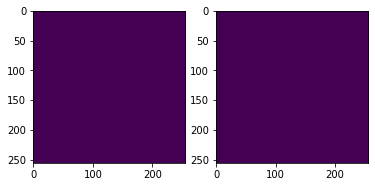

In [5]:
batch= next(iter(train_loader))
images, true_masks = batch
print(images.shape, true_masks.shape)
images.min(), images.max(), true_masks.min(), true_masks.max()
plt.subplot(121)
plt.imshow(true_masks[1,1,:,:])
plt.subplot(122)
plt.imshow(true_masks[0,1,:,:])


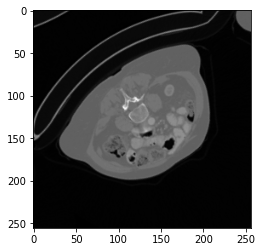

In [7]:
img = images[0,:,:]
plt.imshow(img[0], cmap="gray")

In [8]:
# (img[0] == img[1]).all(), (img[0] == img[2]).all(), (img[1] == img[2]).all()
images.min(), images.max()

(tensor(0.), tensor(244.6094))

In [5]:
# df_loss = monai.losses.DiceFocalLoss()
df_loss = monai.losses.DiceLoss()

In [7]:
df_loss(true_masks[:,1,:,:], true_masks[:,1,:,:]), df_loss(true_masks, true_masks)

(tensor(0.), tensor(0.))

In [51]:
# true_masks[0,1,:,:]
l_mask = true_masks[0,0,:,:]
t_mask = true_masks[0,1,:,:]

In [63]:
t_mask.min(), t_mask.max()

(tensor(0.), tensor(1.0000))

tensor(0) tensor(1) tensor([0, 1])


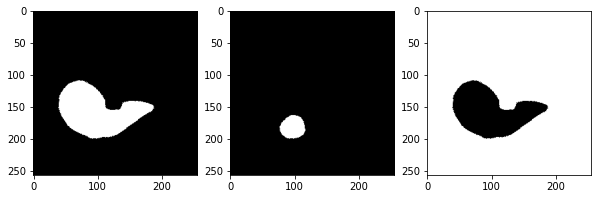

In [102]:
# c_mask = torch.where(l_mask==1, 1, 0)
# c_mask = torch.where(t_mask > 0 , 0, torch.ones(t_mask.shape))
# c_mask = torch.where(l_mask > 0.5, 0, 1)
c_mask = torch.where(l_mask ==0, 1, 0)

print(c_mask.min(), c_mask.max(), c_mask.unique())

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(l_mask, cmap="gray")
plt.subplot(132)
plt.imshow(t_mask, cmap="gray")
plt.subplot(133)
plt.imshow(c_mask, cmap="gray")

In [69]:
c_mask2 = t_mask + l_mask

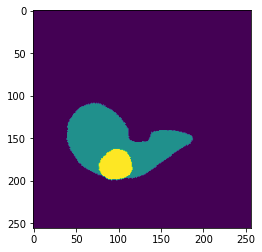

In [71]:
plt.imshow(c_mask2)

In [55]:
# plt.imshow(t_mask)
# plt.imshow(l_mask)

In [25]:
from monai.losses.dice import *  # NOQA
import torch
from monai.losses.dice import DiceLoss


In [20]:
B, C, H, W = 7, 5, 3, 2
input = torch.rand(B, C, H, W)
target_idx = torch.randint(low=0, high=C - 1, size=(B, H, W)).long()
target = one_hot(target_idx[:, None, ...], num_classes=C)
self = Dice()
loss = self(input, target)
assert np.broadcast_shapes(loss.shape, input.shape) == input.shape

In [68]:
target_idx.shape, target.shape, input.shape

(torch.Size([7, 3, 2]), torch.Size([7, 5, 3, 2]), torch.Size([7, 5, 3, 2]))

In [69]:
# target[0]
# input[0][0], target[0][0]
loss

tensor(1.0969)

In [115]:
def dice_loss(pred, target, smooth=1e-6):
    """
    Calculate the Dice Loss for a single class.
    Args:
        pred: predicted mask of shape (batch_size, H, W)
        target: ground truth mask of shape (batch_size, H, W)
        smooth: smoothing value to avoid division by zero
    Returns:
        Dice Loss for the given class.
    """
    intersection = (pred * target).sum(dim=(1, 2))
    # if intersection.sum() < 0:
    #     print(f'intersection: {intersection}')
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2))
    # if union.sum() < 0:
    #     print(f'union: {union}')
    dice = (2 * intersection + smooth) / (union + smooth)
    # if dice.mean() <0 or dice.mean() > 1:
    #     print(f'dice.mean(): {dice.mean()}')
        # return torch.tensor(1.0, requires_grad=True).to(device)
    # if dice.mean() <0:
        # print(f'dice.mean(): {dice.mean()}')
        # return torch.tensor(1.0, requires_grad=True).to(device)
    return 1 - dice.mean()

def multi_class_dice_loss(preds, targets, smooth=1):
    """
    Calculate the multi-class Dice Loss.
    Args:
        preds: predicted masks of shape (batch_size, num_classes, H, W)
        target: ground truth mask of shape (batch_size, H, W)
        smooth: smoothing value to avoid division by zero
    Returns:
        Average Dice Loss across all classes.
    """
    num_classes = preds.shape[1]
    total_loss = 0
    for i in range(num_classes):
        pred = preds[:, i, :, :]
        # target_class = (target == i+1).float() # i+1 for class 1 and 2 (0 is not a class)
        target_class = targets[:,i,:,:] # i+1 for class 1 and 2 (0 is not a class)
        dice_l = dice_loss(pred, target_class, smooth=smooth)
        # if dice_l < 0:
            # print(f'dice_l: {dice_l}')
        total_loss += dice_l
    # num_classes = -num_classes
    # if total_loss < 0 or total_loss / num_classes < 0 or total_loss / num_classes > 1:
        # print(f'total_loss: {total_loss / num_classes}')
    return total_loss / num_classes

In [116]:
temp_1 = torch.ones(masks.shape, dtype=torch.float32)
temp_0 = torch.zeros(masks.shape, dtype=torch.float32)

In [ ]:
for imgs, masks in tqdm(train_loader):
    ls = multi_class_dice_loss(masks, temp_0*255)
    if ls < 0 or ls > 1:
        print(f'Out: {ls}')
        break
    # print(multi_class_dice_loss(masks, masks))
    # print(i[0].shape, i[1].shape)
    # break

In [106]:
imgs.min(), imgs.max(), masks.min(), masks.max()

(tensor(0.), tensor(0.9875), tensor(0.), tensor(1.0000))

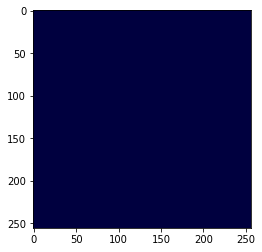

In [60]:
plt.imshow(masks[0][0], cmap='gray')
plt.imshow(masks[0][1], alpha=0.5, cmap='jet')

## UNETR

In [2]:
import segmentation_models_pytorch as smp

In [3]:
loss = smp.utils.losses.DiceLoss()

AttributeError: module 'segmentation_models_pytorch' has no attribute 'utils'

In [ ]:
loss

In [1]:
import segmentation_models_pytorch as smp


In [6]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [7]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)


In [5]:
model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## WandB

In [21]:
import wandb
import matplotlib.pyplot as plt

In [22]:
wandb.login(key="3294888d6e8770f81c41bc9fbe6c00668c21d288")

wandb: Currently logged in as: aneeshashmi (biomedai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/anees.hashmi/.netrc


True

In [25]:
x_values = range(100)
y_values = [x**2 for x in x_values]

data = [[x, y] for (x, y) in zip(x_values, y_values)]


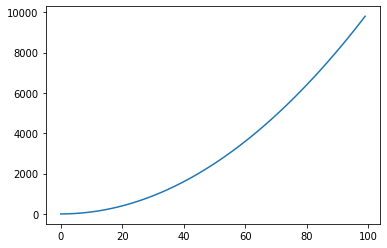

In [26]:
plt.plot(x_values, y_values)

In [27]:
# table = wandb.Table(data=data, columns = ["x", "y"])
# wandb.log({"my_custom_plot_id" : wandb.plot.line(table, "x", "y",
#            title="Custom Y vs X Line Plot")})

In [30]:
# wandb.init(project="test 1", entity="test1")
# wandb.init(project="my-project-name", entity="my-entity-name")
# Step 3: Log a scalar value

In [31]:
# wandb.log({"accuracy": 0.85})

# Step 4: Finish the run
# wandb.finish()

In [36]:
import wandb


In [37]:

# Step 1: Set your API key
api_key = '3294888d6e8770f81c41bc9fbe6c00668c21d288'
wandb.login(key=api_key)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/anees.hashmi/.netrc


True

In [39]:

# Step 2: Initialize a new wandb run
wandb.init(project="my-project-name", entity="my-entity-name")

# Step 3: Log a scalar value
wandb.log({"accuracy": 0.85})

# Step 4: Finish the run
wandb.finish()


Problem at: /tmp/ipykernel_2272152/2752110598.py 2 <cell line: 2>


Traceback (most recent call last):
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1078, in init
    run = wi.init()
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 574, in init
    manager._inform_init(settings=self.settings, run_id=self.settings.run_id)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/wandb_manager.py", line 173, in _inform_init
    svc_iface._svc_inform_init(settings=settings, run_id=run_id)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/service/service_sock.py", line 38, in _svc_inform_init
    self._sock_client.send(inform_init=inform_init)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/lib/sock_client.py", line 211, in send
    self.send_server_request(server_req)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/wandb/sdk/lib

Exception: problem

In [1]:
import torch.nn as nn
import torch
# import smp
# import segmentation_models_pytorch as smp
import monai

In [22]:
criterion_ce = nn.CrossEntropyLoss()
iou = monai.metrics.compute_meaniou
criterion_dice = monai.losses.DiceLoss() 
criterion_bce = nn.BCEWithLogitsLoss()

In [48]:
gt = torch.zeros((1, 3, 256, 256), dtype=torch.float32)
pred = torch.ones((1, 3, 256, 256), dtype=torch.float32)

In [59]:
loss_ce = criterion_ce(pred, gt)
loss_bce = criterion_bce(pred, gt)
loss_dice = criterion_dice(pred, gt)

mean_iou = iou(pred, gt).mean()
# print(mean_iou)
if mean_iou.isnan():
    mean_iou = torch.tensor(0.0, requires_grad=True)
    # print(f'mean_iou: {mean_iou}')

/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <function compute_meaniou at 0x7f6ffb174a60>: Function `compute_meaniou` has been deprecated since version 1.0.0. use `compute_iou` instead.
  warn_deprecated(obj, msg, warning_category)


In [60]:
loss_bce, loss_ce, loss_dice, mean_iou

(tensor(1.3133), tensor(-0.), tensor(1.), tensor(0., requires_grad=True))

In [67]:
import os

In [70]:
# x = [{'name':}]

In [1]:
import torch
import matplotlib.pyplot as plt
# import softmax from torch.nn.functional as F
import torch.nn.functional as F
import numpy as np

In [95]:
pred_masks = torch.load('./pred.pt')
# pred_masks = F.softmax(pred_masks, dim=1)
gt_masks = torch.load('./true_masks.pt')

In [4]:
# convert gt_masks to numpy array
gt_masks = gt_masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

In [5]:
pred_masks.shape, gt_masks.shape

((2, 3, 256, 256), (2, 3, 256, 256))

In [6]:
pred_mask_1 = pred_masks[:,0,:,:]
pred_mask_2 = pred_masks[:,1,:,:]

gt_mask_1 = gt_masks[:,0,:,:]
gt_mask_2 = gt_masks[:,1,:,:]

pred_mask_1.shape, pred_mask_2.shape, gt_mask_1.shape, gt_mask_2.shape

((2, 256, 256), (2, 256, 256), (2, 256, 256), (2, 256, 256))

In [11]:
sigmoid = torch.nn.Sigmoid()
softmax = torch.nn.Softmax(dim=1)

In [14]:
sig = sigmoid(torch.from_numpy(pred_masks))

In [15]:
sig

tensor([[[[0.9180, 0.9519, 0.9399,  ..., 0.9775, 0.9696, 0.9135],
          [0.9623, 0.9834, 0.9811,  ..., 0.9956, 0.9921, 0.9597],
          [0.9436, 0.9756, 0.9747,  ..., 0.9972, 0.9932, 0.9502],
          ...,
          [0.9544, 0.9777, 0.9768,  ..., 0.9997, 0.9977, 0.9722],
          [0.9605, 0.9807, 0.9777,  ..., 0.9976, 0.9927, 0.9542],
          [0.9025, 0.9566, 0.9522,  ..., 0.9807, 0.9655, 0.9083]],

         [[0.5110, 0.4851, 0.5028,  ..., 0.4816, 0.4891, 0.4805],
          [0.4523, 0.4788, 0.4764,  ..., 0.4718, 0.4635, 0.4881],
          [0.4726, 0.4787, 0.4993,  ..., 0.4873, 0.4602, 0.4762],
          ...,
          [0.4626, 0.4824, 0.5034,  ..., 0.4698, 0.4450, 0.4610],
          [0.4654, 0.4712, 0.4960,  ..., 0.4509, 0.4350, 0.4550],
          [0.4748, 0.4888, 0.4949,  ..., 0.4711, 0.4623, 0.4872]],

         [[0.7722, 0.8090, 0.8182,  ..., 0.8477, 0.8081, 0.7427],
          [0.7945, 0.8734, 0.8727,  ..., 0.9084, 0.8840, 0.7918],
          [0.7954, 0.8676, 0.8534,  ..., 0

In [13]:
sigmoid(torch.from_numpy(pred_masks)).shape, softmax(torch.from_numpy(pred_masks)).shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256]))

In [16]:
import torch
import numpy as np

In [17]:

input_torch = torch.randn(1, 3, 2, 5, requires_grad=True)

one_hot = np.array([[[1, 1, 1, 0, 0], [0, 0, 0, 0, 0]],    
                    [[0, 0, 0, 0, 0], [1, 1, 1, 0, 0]],
                    [[0, 0, 0, 1, 1], [0, 0, 0, 1, 1]]])


In [19]:
one_hot.shape, input_torch.shape

((3, 2, 5), torch.Size([1, 3, 2, 5]))

In [ ]:
target = np.array([np.argmax(a, axis = 0) for a in target])
target_torch = torch.tensor(target)

loss = torch.nn.CrossEntropyLoss()
output = loss(input_torch, target_torch)

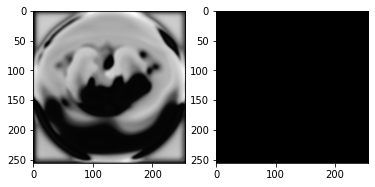

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(pred_mask_1[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(gt_mask_1[0], cmap='gray')

In [51]:
# Example of target with class indices
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)


In [52]:
input

tensor([[ 0.7910, -1.3449,  0.5970, -1.3493, -0.1175],
        [ 0.5718,  2.1184, -0.3704,  0.3232, -0.9558],
        [ 0.1300, -2.4126, -2.0391, -0.2619, -0.8972]], requires_grad=True)

In [30]:
input.shape, target.shape

(torch.Size([3, 5]), torch.Size([3]))

In [45]:
output = loss(input, target)
# output.backward()
# Example of target with class probabilities


In [46]:
output

tensor(2.1831, grad_fn=<NllLossBackward0>)

In [47]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output, output.shape, target.shape, input.shape
# output.backward()

(tensor(2.3098, grad_fn=<DivBackward1>),
 torch.Size([]),
 torch.Size([3, 5]),
 torch.Size([3, 5]))

In [50]:
input

tensor([[ 1.3832,  1.4973,  0.0583,  0.4506, -0.0287],
        [-0.6238, -1.2937,  0.4722, -2.3618, -0.9937],
        [ 1.6353, -0.5630, -0.9219, -0.3410, -0.8511]], requires_grad=True)

In [1]:
import torch
import torch.nn as nn

In [2]:
m = nn.Sigmoid()
input = torch.randn(2)
output = m(input)

In [5]:
m = nn.Sigmoid()
loss = nn.BCELoss()


In [12]:
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)

In [18]:
output = loss(m(input), target)


In [15]:
print(target.shape, target.min(), target.max())
# print(output.shape, output.min(), output.max())


torch.Size([3]) tensor(0.) tensor(1.)


/tmp/ipykernel_1667974/3139126078.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(target)


In [22]:
from torchmetrics import JaccardIndex


In [23]:
target = torch.randint(0, 1, (10, 25, 25))
pred = torch.tensor(target)

pred[2:5, 7:13, 9:15] = 1 - pred[2:5, 7:13, 9:15]
jaccard = JaccardIndex(task="multiclass", num_classes=2)
jaccard(pred, target)

tensor(0.9660)

In [25]:
pred.shape, target.shape

(torch.Size([10, 25, 25]), torch.Size([10, 25, 25]))

In [2]:

import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                  [1, 0, 0]])

In [4]:
jaccard_score(y_true.ravel(), y_pred.ravel())

0.6

In [6]:
(jaccard_score(y_true[0], y_pred[0]) + jaccard_score(y_true[1], y_pred[1]))/2

0.5833333333333333

In [7]:
from torchmetrics import JaccardIndex

In [9]:
import torch

In [53]:
# pred = torch.tensor(target)
# pred[2:5, 7:13, 9:15] = 1 - pred[2:5, 7:13, 9:15]
# jaccard = JaccardIndex(num_classes=2, task="multiclass")

In [42]:
target = torch.randint(0, 1, (10, 2, 25, 25))
pred =  torch.randint(0, 1, (10, 2, 25, 25))
result = jaccard(pred, target)
print(pred.shape, target.shape)
result

torch.Size([10, 2, 25, 25]) torch.Size([10, 2, 25, 25])


tensor(0.5000)

In [59]:
# num_classes = 2
iou_metric = JaccardIndex(num_classes = 2, reduction='none', task='multiclass')

height, width = 255, 255

# Flatten the tensors
y_true = torch.randint(0, 1, (10, 2, height, width))
y_pred = torch.randint(0, 1, (10, 2, height, width))

y_true_flat = y_true.view(-1, height, width)
y_pred_flat = y_pred.view(-1, height, width)



In [60]:
# Compute the IoU for each class separately
iou_per_class = iou_metric(y_pred_flat, y_true_flat)

# Take the average across all classes
jaccard_score = torch.mean(iou_per_class)


In [63]:
iou_per_class, jaccard_score

(tensor(0.5000), tensor(0.5000))

In [64]:
from torchmetrics.classification import MulticlassJaccardIndex

In [87]:
# target = torch.tensor([2, 1, 0, 0])

preds = torch.tensor([
  [0.16, 0.26, 0.58],
  [0.22, 0.61, 0.17],
  [0.71, 0.09, 0.20],
  [0.05, 0.82, 0.13],
])
target = torch.randint(0, 2, preds.shape)
metric = MulticlassJaccardIndex(num_classes=2, average='macro')
metric2 = MulticlassJaccardIndex(num_classes=2)


In [88]:
target

tensor([[0, 0, 1],
        [0, 1, 0],
        [1, 1, 1],
        [1, 1, 1]])

In [90]:
metric(preds, target), metric2(preds, target)

(tensor(0.1667), tensor(0.1667))

In [86]:
target.shape, preds.shape

(torch.Size([4, 3]), torch.Size([4, 3]))

In [91]:
from utils import check_accuracy

In [96]:
pred_masks = torch.load('./pred.pt')
# pred_masks = F.softmax(pred_masks, dim=1)
gt_masks = torch.load('./true_masks.pt')

In [97]:
pred_masks.shape, gt_masks.shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256]))

In [99]:
gt_masks.unique()

tensor([0., 1.], device='cuda:0', dtype=torch.float64)

In [106]:
y = gt_masks.unsqueeze(1)
# y.shape, 

In [107]:
y = (pred_masks > 0.5).float()
y.shape

torch.Size([2, 3, 256, 256])

In [110]:
num_correct = (y == gt_masks).sum()
num_pixels = torch.numel(gt_masks)
num_correct, num_pixels, num_correct / num_pixels

(tensor(166864, device='cuda:0'), 393216, tensor(0.4244, device='cuda:0'))